# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [364]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [365]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [366]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [367]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [368]:
# define a function to load json file to a dataframe
from google.colab import drive
def mount_drive():
  drive.mount('/content/gdrive')

def load_json_dataframe(file_path):
  mount_drive()
  try:
    with open(file_path, 'r') as file:
      data = json.load(file)
      df = pd.DataFrame(data)
    return df
  except Exception as e:
      print(f"An Error occurred: {e}")
      return None

Mount Google drive, read file

In [369]:
file_path = "/content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/NLP_Assessment_1_Recipe/ingredient_and_quantity.json"

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [370]:
# read the json fil by giving the file path and create a dataframe
df = load_json_dataframe(file_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [371]:
# display first five rows of the dataframe - df
df.head(5)

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [372]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [373]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [374]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
nlp=spacy.load("en_core_web_sm")
# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: [token.text for token in nlp(x)])
# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: [token.text for token in nlp(x)])

In [375]:
# display first five rows of the dataframe - df
df.head(5)

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2, -, 1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1, -, 1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1, -, 1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient in

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [376]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].str.len()
df['pos_length'] = df['pos_tokens'].str.len()
df.head(1)

,input,pos,input_tokens,pos_tokens,input_length,pos_length
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31


In [377]:
# check for the equality of input_length and pos_length in the dataframe
unequal_rows = df[df['input_length'] != df['pos_length']]

In [378]:
unequal_rows.index

Index([  1,   2,  13,  17,  23,  27,  33,  37,  42,  46,  48,  58,  60,  63,
        65,  69,  71,  73,  74,  77,  79,  82,  84,  86,  87,  94, 100, 107,
       110, 111, 112, 114, 121, 130, 133, 146, 147, 150, 152, 154, 156, 157,
       158, 159, 163, 164, 168, 173, 176, 183, 185, 188, 190, 192, 196, 203,
       204, 205, 207, 216, 218, 219, 221, 222, 226, 228, 234, 239, 241, 242,
       243, 244, 245, 247, 250, 251, 258, 261, 265, 268, 277],
      dtype='int64')

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [379]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(dataframe):
    unique_pos_labels = set()
    for pos_tokens in dataframe['pos_tokens']:
        unique_pos_labels.update(pos_tokens)
    print(unique_pos_labels)
unique_labels(df)

{'unit', 'quantity', 'ingredient'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
1,   2,  13,  17,  23,  27,  33,  37,  42,  46,  48,  58,  60,  63,
        65,  69,  71,  73,  74,  77,  79,  82,  84,  86,  87,  94, 100, 107,
       110, 111, 112, 114, 121, 130, 133, 146, 147, 150, 152, 154, 156, 157,
       158, 159, 163, 164, 168, 173, 176, 183, 185, 188, 190, 192, 196, 203,
       204, 205, 207, 216, 218, 219, 221, 222, 226, 228, 234, 239, 241, 242,
       243, 244, 245, 247, 250, 251, 258, 261, 265, 268, 277


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [380]:
# drop the irrelevant recipe data
df = df.drop(unequal_rows.index)

In [381]:
df.shape

(204, 6)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [382]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].str.len()
df['pos_length'] = df['pos_tokens'].str.len()

In [383]:
df[['input_length','pos_length']].head()

,input_length,pos_length
0,31,31
3,46,46
4,21,21
5,41,41
6,39,39


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [384]:
# validate the input length and pos length as input_length and pos_length
unequal_rows = df[df['input_length'] != df['pos_length']]
unequal_rows

,input,pos,input_tokens,pos_tokens,input_length,pos_length


No unequal records, so we are good now.

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [385]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

In [386]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)

Training set shape: (142, 6)
Validation set shape: (62, 6)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [387]:
# print the first five rows of train_df
train_df.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length
132,1 cup Gram flour besan 1/2 teaspoon Ajwain Carom seeds 1/4 Red Chilli powder 2 tablespoons Curd Dahi Yogurt Sunflower Oil Green Bell Pepper Capsicum Cumin Asafoetida hing Turmeric Garam masala Amchur Dry Mango Powder Coriander Dhania 4 sprig Leaves chopped,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient,"[1, cup, Gram, flour, besan, 1/2, teaspoon, Ajwain, Carom, seeds, 1/4, Red, Chilli, powder, 2, tablespoons, Curd, Dahi, Yogurt, Sunflower, Oil, Green, Bell, Pepper, Capsicum, Cumin, Asafoetida, hing, Turmeric, Garam, masala, Amchur, Dry, Mango, Powder, Coriander, Dhania, 4, sprig, Leaves, chopped]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",41,41
39,1 eggplant 2 inch ginger onion tomato green chillies teaspoon turmeric powder garam masala coriander tablespoon butter red chili oil sprigs of,quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient,"[1, eggplant, 2, inch, ginger, onion, tomato, green, chillies, teaspoon, turmeric, powder, garam, masala, coriander, tablespoon, butter, red, chili, oil, sprigs, of]","[quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient]",22,22
15,2 onions 1 teaspoon cumin seeds tablespoons black urad dal split tamarind paste 3 dry red chillies 1/2 jaggery teaspoons oil salt sprig curry leaves,quantity ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient unit ingredient ingredient unit ingredient ingredient,"[2, onions, 1, teaspoon, cumin, seeds, tablespoons, black, urad, dal, split, tamarind, paste, 3, dry, red, chillies, 1/2, jaggery, teaspoons, oil, salt, sprig, curry, leaves]","[quantity, ingredient, quantity, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, unit, ingredient, ingredient]",25,25
44,2 cups Makki Ka Atta Yellow Corn Meal Flour 1 1/2 Methi Leaves Fenugreek chopped Green Chillies tablespoon Ajwain Carom seeds Kashmiri Red Chilli Powder Salt,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity quantity ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[2, cups, Makki, Ka, Atta, Yellow, Corn, Meal, Flour, 1, 1/2, Methi, Leaves, Fenugreek, chopped, Green, Chillies, tablespoon, Ajwain, Carom, seeds, Kashmiri, Red, Chilli, Powder, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredien

In [388]:
# print the first five rows of the val_df
val_df.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length
19,1 cup rice 12 small onions 2 cloves garlic inch ginger green chillies bay leaf tsp red chilli powder turmeric carrot beans potatoes ghee cinnamon fennel whole pepper coriander seeds 1/4 peas mint leaves,quantity unit ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[1, cup, rice, 12, small, onions, 2, cloves, garlic, inch, ginger, green, chillies, bay, leaf, tsp, red, chilli, powder, turmeric, carrot, beans, potatoes, ghee, cinnamon, fennel, whole, pepper, coriander, seeds, 1/4, peas, mint, leaves]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",34,34
11,2 Burger buns 5 Pickled Jalapenos sliced Cheese Slices Potatoes Aloo pressure cooked 1 Onion chopped tablespoon Red Chilli powder Salt Whole Egg 1/2 cup Wheat Bread crumbs 4 cloves Garlic Onions Tomatoes Homemade tomato puree Green Bell Pepper Capsicum Soy granules teaspoon flakes Cumin Jeera Dried oregano Tabasco Original Hot Sauce Honey Sunflower Oil,quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[2, Burger, buns, 5, Pickled, Jalapenos, sliced, Cheese, Slices, Potatoes, Aloo, pressure, cooked, 1, Onion, chopped, tablespoon, Red, Chilli, powder, Salt, Whole, Egg, 1/2, cup, Wheat, Bread, crumbs, 4, cloves, Garlic, Onions, Tomatoes, Homemade, tomato, puree, Green, Bell, Pepper, Capsicum, Soy, granules, teaspoon, flakes, Cumin, Jeera, Dried, oregano, Tabasco, Original, Hot, Sauce, Honey, Sunflower, Oil]","[quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",55,55
155,1/4 cup Rice Yellow Moong Dal 1 Carrot Gajjar 3 Green beans French Beans teaspoon Ghee Cumin seeds Asafoetida hing Salt a pinch,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit,"[1/4, cup, Rice, Yellow, Moong, Dal, 1, Carrot, Gajjar, 3, Green, beans, French, Beans, teaspoon, Ghee, Cumin, seeds, Asafoetida, hing, Salt, a, pinch]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit]",23,23
105,4 Potatoes Aloo 50 grams Mo

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [389]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()


In [390]:
# validate the shape of training and validation samples
print("X_train length:", len(X_train))
print("y_train length:", len(y_train))
print("X_val length:", len(X_val))
print("y_val length:", len(y_val))

X_train length: 142
y_train length: 142
X_val length: 62
y_val length: 62


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [391]:
# Display the number of unique labels present in y_train
flat_y_train = [item for sublist in y_train for item in sublist]
unique_labels_y_train = set(flat_y_train)
print(unique_labels_y_train)

{'unit', 'quantity', 'ingredient'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [392]:
# flatten the list for nested_list (input_tokens, pos_tokens)
flatten_list = lambda nested_list: [item for sublist in nested_list for item in sublist]

In [393]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [394]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens


def extract_and_validate_tokens(df, dataset_name):
    # Apply flatten_list to input_tokens and pos_tokens
    input_tokens_flat = flatten_list(df['input_tokens'].tolist())
    pos_tokens_flat = flatten_list(df['pos_tokens'].tolist())

    if(len(input_tokens_flat) != len(pos_tokens_flat)):
        print(f"{dataset_name} - tokens and pos length is not matching")
    # Validate lengths
    print(f"Length of flattened input tokens in {dataset_name} dataset: ", len(input_tokens_flat))
    print(f"Length of flattened pos tokens in {dataset_name} dataset: ", len(pos_tokens_flat))
    return input_tokens_flat, pos_tokens_flat

In [395]:
# extract the tokens and its pos tags
train_input_tokens_flat, train_pos_tokens_flat = extract_and_validate_tokens(train_df, dataset_name)

# Display first 10 records
print(f"\nFirst 10 input tokens in {dataset_name} dataset:")
print(train_input_tokens_flat[:10])
print(f"\nFirst 10 pos tokens in {dataset_name} dataset:")
print(train_pos_tokens_flat[:10])

Length of flattened input tokens in Training dataset:  4632
Length of flattened pos tokens in Training dataset:  4632

First 10 input tokens in Training dataset:
['1', 'cup', 'Gram', 'flour', 'besan', '1/2', 'teaspoon', 'Ajwain', 'Carom', 'seeds']

First 10 pos tokens in Training dataset:
['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']


In [396]:
# extract the tokens and its pos tags
val_input_tokens_flat, val_pos_tokens_flat = extract_and_validate_tokens(val_df, 'Validation')

# Display first 10 records
print(f"\nFirst 10 input tokens in Validation dataset:")
print(val_input_tokens_flat[:10])
print(f"\nFirst 10 pos tokens in Validation dataset:")
print(val_pos_tokens_flat[:10])

Length of flattened input tokens in Validation dataset:  2149
Length of flattened pos tokens in Validation dataset:  2149

First 10 input tokens in Validation dataset:
['1', 'cup', 'rice', '12', 'small', 'onions', '2', 'cloves', 'garlic', 'inch']

First 10 pos tokens in Validation dataset:
['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'unit']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [397]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    if not isinstance(tokens, list) or not isinstance(pos_tags, list) or len(tokens) != len(pos_tags):
        return [], [], []  # Return empty lists for invalid input

    ingredients = []
    units = []
    quantities = []

    valid_labels = {'ingredient', 'unit', 'quantity'}
    if not all(tag in valid_labels for tag in set(pos_tags)):
        return [], [], [] # Return empty lists if pos tags are not valid


    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            ingredients.append(token)
        elif tag == 'unit':
            units.append(token)
        elif tag == 'quantity':
            quantities.append(token)

    return ingredients, units, quantities


In [398]:
#  call the function to categorise the labels into respective list
train_ingredients, train_units, train_quantities = categorize_tokens(train_input_tokens_flat, train_pos_tokens_flat)

In [399]:
train_ingredients[:5]

['Gram', 'flour', 'besan', 'Ajwain', 'Carom']

In [400]:
train_units[:5]

['cup', 'teaspoon', 'tablespoons', 'sprig', 'inch']

In [401]:
train_quantities[:5]

['1', '1/2', '1/4', '2', '4']

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [402]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name, count=10):
    # Count the occurrences of each item
    item_counts = Counter(item_list)

    # Get the top most frequent items
    top_items = item_counts.most_common(count)

    print(f"Top most frequent {pos_label}s in {dataset_name} dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items

In [403]:
# get the top ingredients which are frequently seen in the recipe
train_top_ingredients = get_top_frequent_items(train_ingredients, "ingredient", dataset_name)

Top most frequent ingredients in Training dataset:
powder: 91
Salt: 68
seeds: 67
Oil: 61
Coriander: 55
chopped: 55
Green: 53
Red: 52
Chilli: 50
Leaves: 49


In [404]:
# get the top units which are frequently seen in the recipe
train_top_units = get_top_frequent_items(train_units, "unit", dataset_name)

Top most frequent units in Training dataset:
teaspoon: 109
cup: 91
tablespoon: 63
tablespoons: 48
grams: 40
inch: 36
cups: 33
sprig: 32
teaspoons: 27
cloves: 25


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [405]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    items, counts = zip(*top_items)
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts)
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.title(f"Top 10 Most Frequent {label}s in {dataset_name} Dataset")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



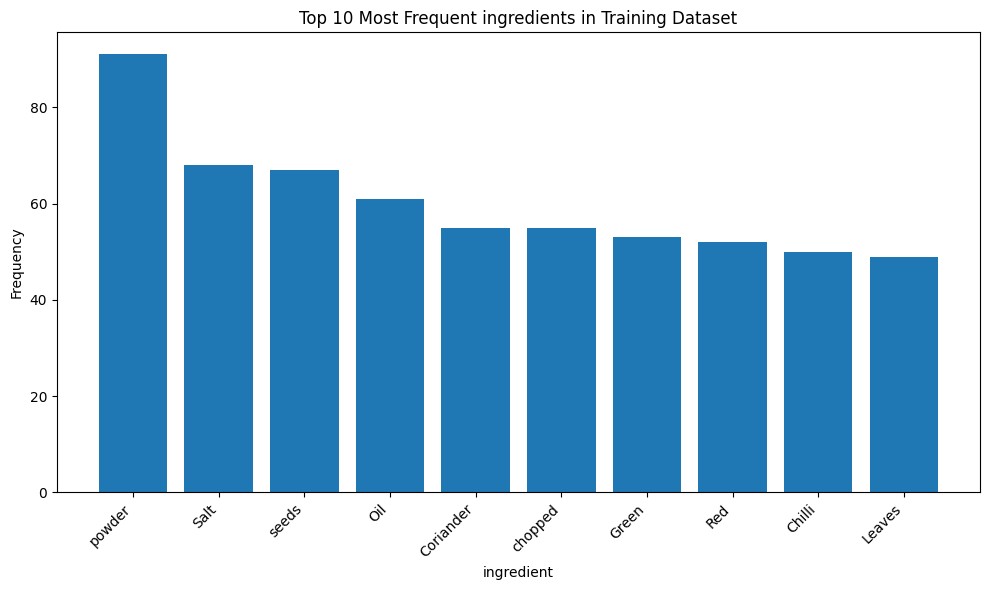

In [406]:
# plot the top frequent ingredients in training data
plot_top_items(train_top_ingredients, "ingredient", dataset_name)

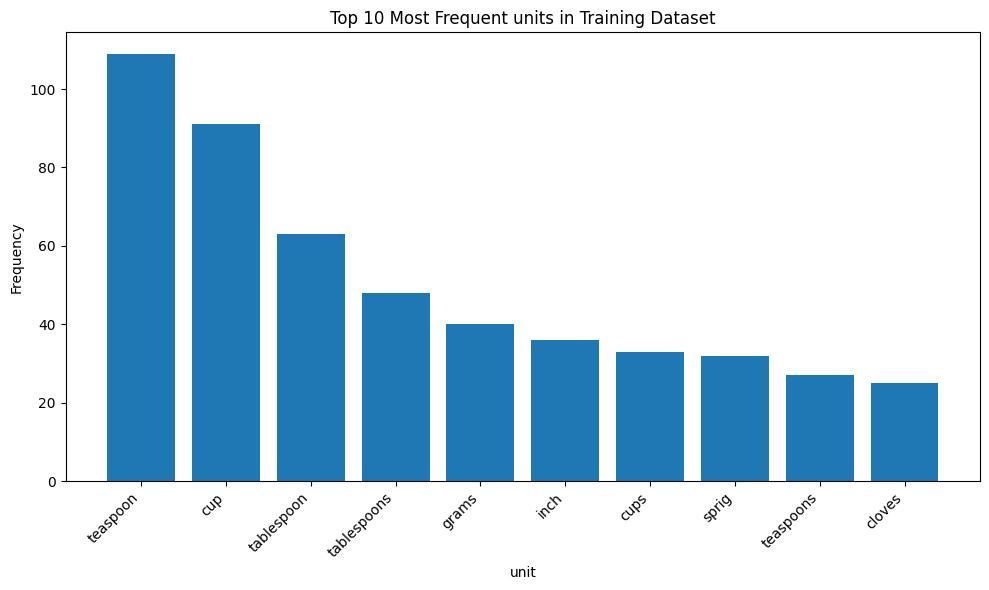

In [407]:
# plot the top frequent units in training data
plot_top_items(train_top_units, "unit", dataset_name)

Insights:
- The most common ingredients are powder and salt.
- "Chopped" and "green" are the most frequent preparation styles.
- The frequent mention of "seeds" indicates a reliance on whole spices (e.g., cumin, mustard).
- Recipes predominantly use teaspoons and cups (almost 50% of unit mentions), followed by tablespoons, less frequent use units like inches and sprigs.

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [408]:
# initialise the dataset_name
dataset_name='Validation'

In [409]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
val_tokens_flat, val_pos_flat = extract_and_validate_tokens(val_df, dataset_name)
val_ingredients, val_units, val_quantities = categorize_tokens(val_tokens_flat, val_pos_flat)

Length of flattened input tokens in Validation dataset:  2149
Length of flattened pos tokens in Validation dataset:  2149


In [410]:
val_top_ingredients = get_top_frequent_items(val_ingredients, "ingredient", dataset_name)

Top most frequent ingredients in Validation dataset:
powder: 42
Salt: 32
Chilli: 27
chopped: 26
Red: 26
seeds: 25
Green: 25
Oil: 25
Leaves: 22
Garlic: 20


In [411]:
val_top_units = get_top_frequent_items(val_units, "unit", dataset_name)

Top most frequent units in Validation dataset:
teaspoon: 46
cup: 45
tablespoon: 32
grams: 19
cloves: 16
inch: 15
tablespoons: 15
sprig: 14
cups: 9
teaspoons: 7


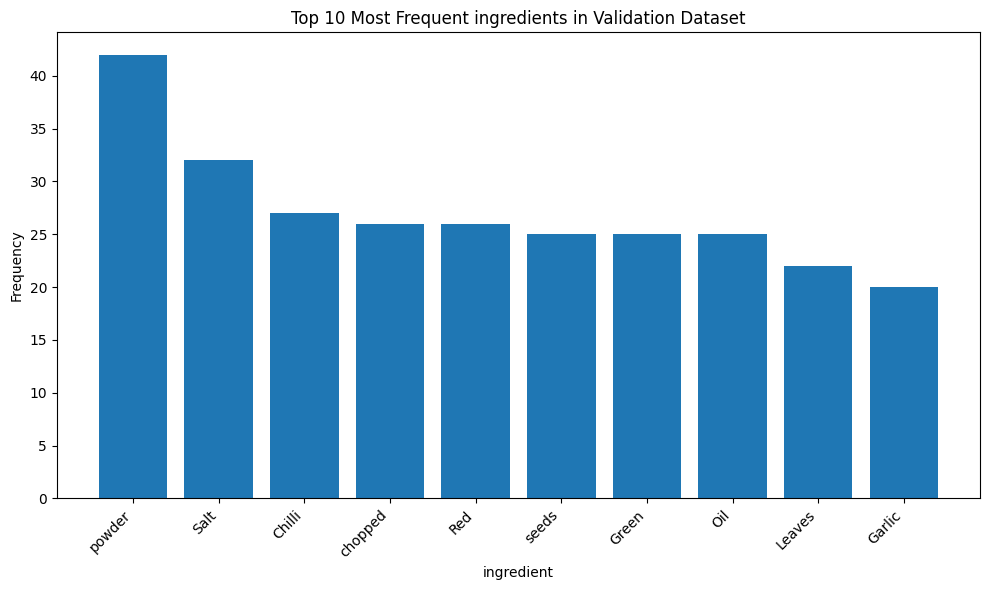

In [412]:
# plot the top frequent ingredients in validation data
plot_top_items(val_top_ingredients, "ingredient", dataset_name)

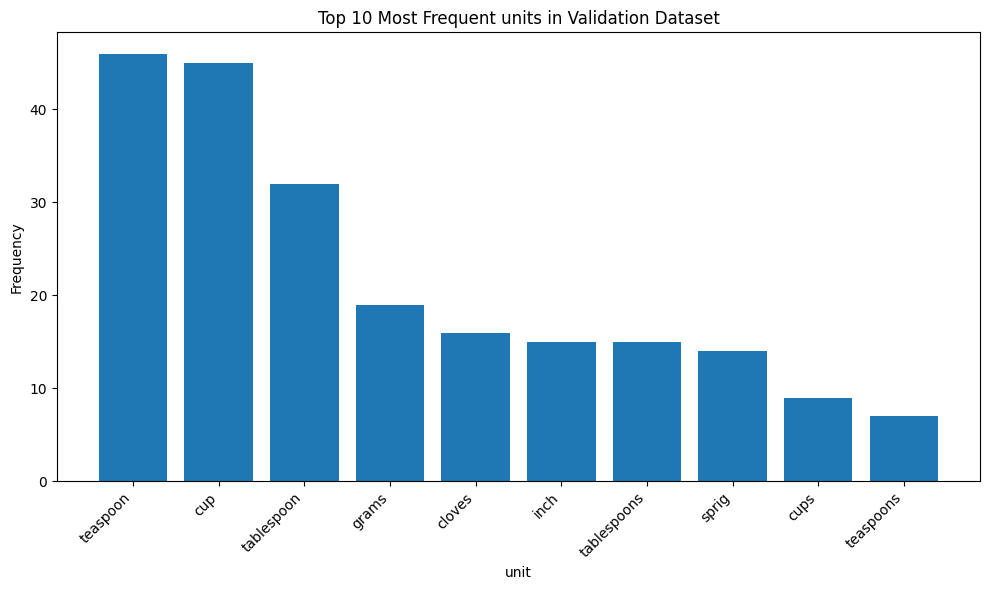

In [413]:
# plot the top frequent units in training data
plot_top_items(val_top_units, "unit", dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [414]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = set(train_units)
quantity_keywords = set(train_quantities)
quantity_pattern = re.compile(r"""
      (?:(?:\d+\s+)?\d+/\d+)|     # Matches '1/2' or '1 1/2'
      \d+\.\d+|                   # Matches decimals like '1.5'
      \d+|                        # Matches whole numbers like '1'
      [¼½¾⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞]     # Matches unicode fractions
    """,
    re.VERBOSE
)

In [415]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [416]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
def word2features(sent, i):
    word = sent[i]
    doc = nlp(word)
    token = doc[0]
    features = {
        'bias': 1.0,
        'token': word.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': word.isdigit(),
        'has_digit': any(char.isdigit() for char in word),
        'has_alpha': any(char.isalpha() for char in word),
        'hyphenated': '-' in word,
        'slash_present': '/' in word,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_punct': token.is_punct,
        'is_quantity': bool(quantity_pattern.match(word)) or word.lower() in quantity_keywords,
        'is_unit': word.lower() in unit_keywords,
        'is_numeric': word.isdigit() or bool(quantity_pattern.match(word)),
        'is_fraction': '/' in word,
        'is_decimal': '.' in word and word.replace('.', '', 1).isdigit(),
    }
    if i > 0:
        prev_word = sent[i - 1]
        features.update({
            'prev_token': prev_word.lower(),
            'prev_is_quantity': bool(quantity_pattern.match(str(prev_word))) or prev_word.lower() in quantity_keywords,
            'prev_is_digit': prev_word.isdigit()
        })
    else:
        features['BOS'] = True
    if i < len(sent) - 1:
        next_word = sent[i + 1]
        features.update({
            'next_token': next_word.lower(),
            'next_is_unit': next_word.lower() in unit_keywords,
            'next_is_ingredient': not (next_word.lower() in unit_keywords or bool(quantity_pattern.match(str(next_word))) or next_word.lower() in quantity_keywords)
        })
    else:
        features['EOS'] = True
    return features


Testing

In [417]:
sent = X_train[0]
feat_dict = word2features(sent, 4)
feat_dict

{'bias': 1.0,
 'token': 'besan',
 'lemma': 'besan',
 'pos_tag': 'PROPN',
 'tag': 'NNP',
 'dep': 'ROOT',
 'shape': 'xxxx',
 'is_stop': False,
 'is_digit': False,
 'has_digit': False,
 'has_alpha': True,
 'hyphenated': False,
 'slash_present': False,
 'is_title': False,
 'is_upper': False,
 'is_punct': False,
 'is_quantity': False,
 'is_unit': False,
 'is_numeric': False,
 'is_fraction': False,
 'is_decimal': False,
 'prev_token': 'flour',
 'prev_is_quantity': False,
 'prev_is_digit': False,
 'next_token': '1/2',
 'next_is_unit': False,
 'next_is_ingredient': False}

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [418]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [419]:
# Example usage (assuming X_train is defined as in the provided code)
sent = X_train[0]
features = sent2features(sent)
features[0]


{'bias': 1.0,
 'token': '1',
 'lemma': '1',
 'pos_tag': 'NUM',
 'tag': 'CD',
 'dep': 'ROOT',
 'shape': 'd',
 'is_stop': False,
 'is_digit': True,
 'has_digit': True,
 'has_alpha': False,
 'hyphenated': False,
 'slash_present': False,
 'is_title': False,
 'is_upper': False,
 'is_punct': False,
 'is_quantity': True,
 'is_unit': False,
 'is_numeric': True,
 'is_fraction': False,
 'is_decimal': False,
 'BOS': True,
 'next_token': 'cup',
 'next_is_unit': True,
 'next_is_ingredient': False}

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [420]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(s) for s in X_train]
X_val_features = [sent2features(s) for s in X_val]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [421]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train
y_val_labels = y_val

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [422]:
# print the length of train features and labels
print(f"Number of training features: {len(X_train_features)}")
print(f"Number of train labels: {len(y_train_labels)}")

Number of training features: 142
Number of train labels: 142


In [423]:
# print the length of validation features and labels
print(f"Number of validation features: {len(X_val_features)}")
print(f"Number of validation labels:   {len(y_val_labels)}")

Number of validation features: 62
Number of validation labels:   62


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [424]:
# Flatten labels in y_train
y_train_flat = [item for sublist in y_train for item in sublist]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [425]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

print(label_counts)
print('Total:',total_samples)

Counter({'ingredient': 3411, 'quantity': 658, 'unit': 563})
Total: 4632


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [426]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {label: total_samples / (count * len(label_counts)) for label, count in label_counts.items()}

weight_dict

{'quantity': 2.346504559270517,
 'unit': 2.742451154529307,
 'ingredient': 0.4526531808853709}

In [427]:
# penalise ingredient label
weight_dict['ingredient'] = weight_dict['ingredient'] * 0.5
weight_dict

{'quantity': 2.346504559270517,
 'unit': 2.742451154529307,
 'ingredient': 0.22632659044268544}

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [428]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    X_features = []
    y_labels = []
    # Apply weights to the features
    for tokens, labels in zip(X, y):
      features = sent2features(tokens)
      scaled_features = []
      for i, feature in enumerate(features):
          label = labels[i]
          weight = weight_dict.get(label, 1.0)
          scaled_feature = {
                key: value * weight if isinstance(value, (int, float)) else value
                for key, value in feature.items()
            }
          scaled_features.append(scaled_feature)
      X_features.append(scaled_features)
      y_labels.append(labels)

    return X_features, y_labels

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [429]:
# Apply manually computed class weights
X_train_weighted_features, y_train_weighted_labels = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features, y_val_weighted_labels = extract_features_with_class_weights(X_val, y_val, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [430]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)
# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_weighted_labels)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [431]:
# evaluate on the training dataset
y_pred_train = crf.predict(X_train_weighted_features)

In [432]:
# specify the flat classification report by using training data for evaluation
print(flat_classification_report(y_train_weighted_labels, y_pred_train))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      3411
    quantity       1.00      1.00      1.00       658
        unit       0.99      1.00      1.00       563

    accuracy                           1.00      4632
   macro avg       1.00      1.00      1.00      4632
weighted avg       1.00      1.00      1.00      4632



In [433]:
# create a confusion matrix on training datset
y_train_true = [item for sublist in y_train_weighted_labels for item in sublist]
y_train_pred = [item for sublist in y_pred_train for item in sublist]
cm = confusion_matrix(y_train_true, y_train_pred, labels=list(set(y_train_true)))


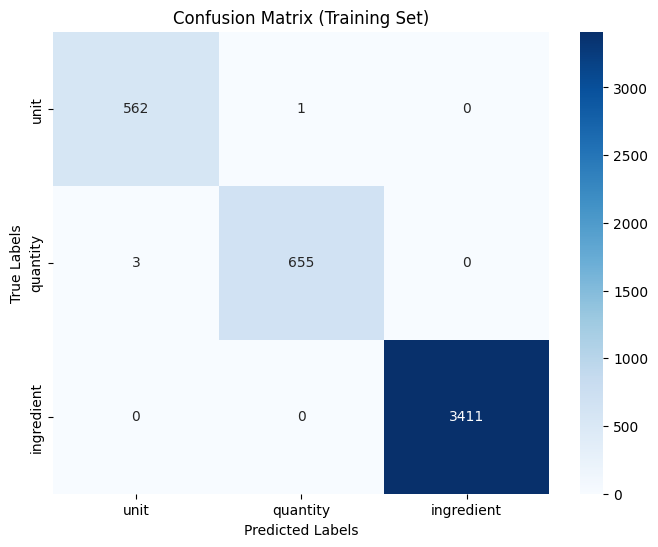

In [434]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y_true_flat)), yticklabels=list(set(y_true_flat)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Set)')
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [435]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [436]:
# predict the crf model on validation dataset
y_pred_val = crf.predict(X_val_weighted_features)

In [437]:
# specify flat classification report
print(flat_classification_report(y_val_weighted_labels, y_pred_val))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      1611
    quantity       1.00      0.99      0.99       294
        unit       0.98      1.00      0.99       244

    accuracy                           1.00      2149
   macro avg       0.99      1.00      1.00      2149
weighted avg       1.00      1.00      1.00      2149



In [438]:
# create a confusion matrix on validation dataset
y_true_flat_val = [item for sublist in y_val_weighted_labels for item in sublist]
y_pred_flat_val = [item for sublist in y_pred_val for item in sublist]
cm_val = confusion_matrix(y_true_flat_val, y_pred_flat_val, labels=list(set(y_true_flat_val)))

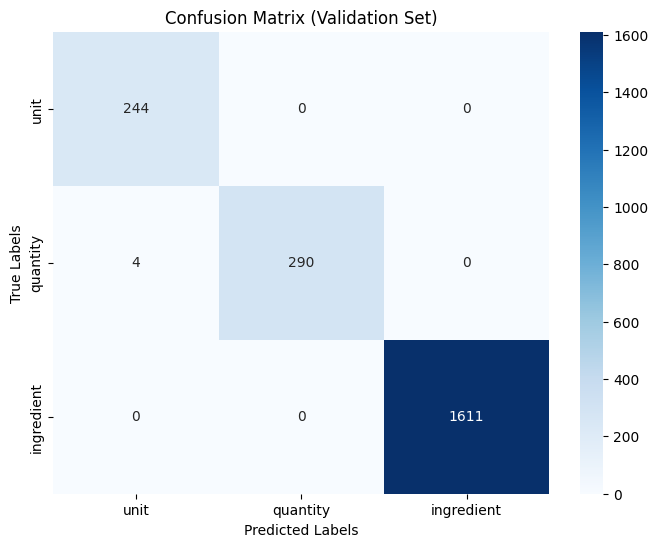

In [439]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=list(set(y_true_flat_val)), yticklabels=list(set(y_true_flat_val)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Validation Set)')
plt.show()


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [440]:
# flatten Labels and Initialise Error Data
y_true_flat_val = [item for sublist in y_val_weighted_labels for item in sublist]
y_pred_flat_val = [item for sublist in y_pred_val for item in sublist]

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [441]:
# iterate and collect Error Information
# Initialize error data
error_data = []

# Iterate through the flattened labels and identify misclassifications
for i in range(len(y_true_flat_val)):
    if y_true_flat_val[i] != y_pred_flat_val[i]:
        error_data.append({
            "true_label": y_true_flat_val[i],
            "predicted_label": y_pred_flat_val[i]
        })

In [442]:
print(len(error_data))
error_data[:10]

4


[{'true_label': 'quantity', 'predicted_label': 'unit'},
 {'true_label': 'quantity', 'predicted_label': 'unit'},
 {'true_label': 'quantity', 'predicted_label': 'unit'},
 {'true_label': 'quantity', 'predicted_label': 'unit'}]

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [443]:
# Create DataFrame and Print Overall Accuracy
correct_predictions = sum(1 for true, pred in zip(y_true_flat_val, y_pred_flat_val) if true == pred)
overall_accuracy = correct_predictions / len(y_true_flat_val) if len(y_true_flat_val) > 0 else 0

print(f"Overall Accuracy on Validation Set: {overall_accuracy * 100:.2f}%")

# Create a DataFrame from error_data (assuming error_data is defined as in the provided code)
error_df = pd.DataFrame(error_data)
print(error_df.head(20))

Overall Accuracy on Validation Set: 99.81%
  true_label predicted_label
0   quantity            unit
1   quantity            unit
2   quantity            unit
3   quantity            unit


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [444]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
label_errors = {}
for label in set(y_true_flat_val):
    label_errors[label] = {
        "true_positives": 0,
        "false_positives": 0,
        "false_negatives": 0,
        "class_weight": weight_dict.get(label, 1.0)
    }

for true_label, pred_label in zip(y_true_flat_val, y_pred_flat_val):
    if true_label == pred_label:
        label_errors[true_label]["true_positives"] += 1
    else:
        label_errors[true_label]["false_negatives"] += 1
        label_errors[pred_label]["false_positives"] += 1

for label, metrics in label_errors.items():
  tp = metrics["true_positives"]
  fn = metrics["false_negatives"]
  fp = metrics["false_positives"]

  if (tp + fn) > 0:
    label_accuracy = tp / (tp+fn)
  else:
    label_accuracy = 0.0
  print(f"Label: {label}")
  print(f"  Class Weight: {metrics['class_weight']:.4f}")
  print(f"  Accuracy: {label_accuracy:.4f}")

# Display error dataframe with additional context
error_rows = []
for i in range(len(X_val)):
    for j in range(len(X_val[i])):
        if y_val_weighted_labels[i][j] != y_pred_val[i][j]:
            prev_token = X_val[i][j - 1] if j > 0 else ""
            next_token = X_val[i][j + 1] if j < len(X_val[i]) - 1 else ""
            context = " ".join(X_val[i][max(0, j - 2):min(len(X_val[i]), j + 3)])
            error_rows.append({
                "token": X_val[i][j],
                "previous_token": prev_token,
                "next_token": next_token,
                "true_label": y_val_weighted_labels[i][j],
                "predicted_label": y_pred_val[i][j],
                "context": context
            })


Label: unit
  Class Weight: 2.7425
  Accuracy: 1.0000
Label: quantity
  Class Weight: 2.3465
  Accuracy: 0.9864
Label: ingredient
  Class Weight: 0.2263
  Accuracy: 1.0000


In [445]:
error_analysis_df = pd.DataFrame(error_rows)
display(error_analysis_df)

,token,previous_token,next_token,true_label,predicted_label,context
0,little,leaves,Salt,quantity,unit,curry leaves little Salt as
1,per,as,taste,quantity,unit,Salt as per taste 1/2
2,taste,per,1/2,quantity,unit,as per taste 1/2 cup
3,a,Leaves,bunch,quantity,unit,Dhania Leaves a bunch finely


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




1. Overall Accuracy - 99.81%
  - The model demonstrates a high overall accuracy on the validation set, indicating its ability to generalize well to unseen data.
2. Label-Wise Performance
  - While the overall accuracy is high, the label-wise performance reveals nuances.
  - Certain labels, ingredient, unit, achieve near-perfect accuracy (100%), suggesting the model effectively identifies it. However, other labels *quantity* show a slightly lower accuracy (98.64%), indicating the model might struggle with more complex names or those with ambiguous contexts

3. Error Analysis Insights
  - The analysis of misclassified samples reveals that the model occasionally misclassifies unit vs quantities. Further investigation of those specific tokens and their contexts is needed.
  - Data quality: If the validation set includes inconsistencies or errors in labelling, they would impact the model's performance.

4.	Class Weights Influence
  - The observed class weights, especially the adjusted weight (2.7425) for 'unit', likely played a role in the model's performance.
  - The lower weight (0.2263) for 'ingredient' indicates an effort to prevent overfitting to the more frequent 'ingredient' class, potentially helping improve the recognition of other labels.
5.	Further Improvement
  - Adding more contextual features: Enhance feature engineering to capture more contextual information.
  - Incorporating more training data: Include more instances of ambiguous or rare ingredients and units in the training data.
  - Adjusting class weights: Fine-tune class weights further to optimize the balance between classes.


## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

- The developed CRF model accurately extracts key entities (ingredients, quantities, and units) from recipe data.
- The model's performance demonstrates its potential for use in recipe management systems and dietary tracking applications.
- However, further refinement is needed to minimize the observed error rate. Specific areas for improvement include:
    - Advanced feature engineering to incorporate more contextual and syntactic information.
    - Augmenting training data with more ambiguous or uncommon ingredient instances.
    - Fine-tuning class weights to optimize performance across different label classes.
    - Addressing ambiguities in unit and ingredient labels to prevent confusion during prediction.
